In [1]:
#Load Libraries
import re
import string
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
from tqdm.auto import tqdm
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import nlpaug.augmenter.word.context_word_embs as aug

#Load Data
df = pd.read_csv('C:/Users/danie/Desktop/Capstone/Dataset/dataset4_prep_rem_blank.csv')
display(df)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,description,tags,tags2
0,ctu firing head,Inventories,Materials
1,psi hydraulic hose,Repair. Upkeep & Maintenance,Operating Assets
2,psi hydraulic hose,Repair. Upkeep & Maintenance,Operating Assets
3,sv custom duty,Repair. Upkeep & Maintenance,Operating Assets
4,cup brush,Repair. Upkeep & Maintenance,Operating Assets
...,...,...,...
13890,zuraiditicket bus kemamankl sani express,Travelling Expenses,Local
13891,zuriadi grab hotel msts asia,Travelling Expenses,Local
13892,zuriadi grab hotelterminal bus pasir gudang,Travelling Expenses,Local
13893,zuriadiclaim add nov telephone bill allw sep o...,Utilities Telephone. Internet & Fax,NaN


<AxesSubplot:>

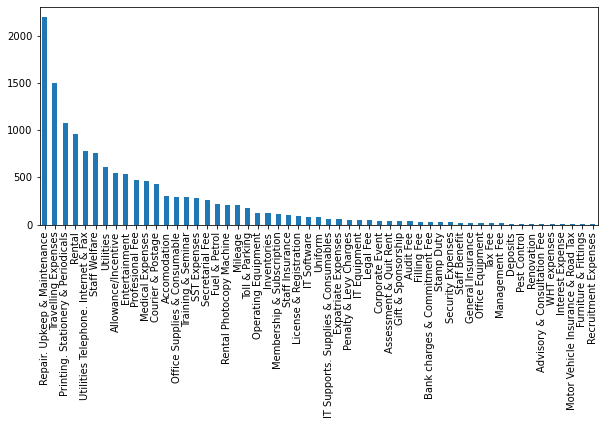

In [2]:
#Class Distribution
plt.figure(figsize=(10,4))
df.tags.value_counts().plot(kind='bar')

In [3]:
#Check Class Balance
df['tags'].value_counts()

Repair. Upkeep & Maintenance           2191
Travelling Expenses                    1501
Printing. Stationery & Periodicals     1074
Rental                                  955
Utilities Telephone. Internet & Fax     779
Staff Welfare                           752
Utilities                               608
Allowance/Incentive                     541
Entertainment                           530
Profesional Fee                         472
Medical Expenses                        463
Courier & Postage                       433
Accomodation                            297
Office Supplies & Consumable            295
Training & Seminar                      294
SST Expenses                            282
Secretarial Fee                         258
Fuel & Petrol                           216
Rental Photocopy Machine                212
Mileage                                 208
Toll & Parking                          180
Operating Equipment                     122
Inventories                     

In [4]:
#Training Validation Split
X = df.description
y = df.tags
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state = 42, stratify=df.tags.values)

In [5]:
#Create Training Dataset
df_train_set = pd.concat([X_train, y_train], axis = 1, sort=False)
df_train_set

,description,tags
7291,invoice tabratas tharom ismayoeddin,Travelling Expenses
11233,print label,Courier & Postage
3590,computer usage,Printing. Stationery & Periodicals
8132,lavender callons tesco,Staff Welfare
6061,hotel badri grabd pink hatyai,Accomodation
...,...,...
12196,sewerage h uzma tower aug,Utilities
11636,rentaloffice equipment,Printing. Stationery & Periodicals
12159,service fee alfa hotel labuan aiedah wan,Accomodation
12371,smr consultancy services feb mida afc tax,Profesional Fee


In [8]:
df_train_set.to_csv(r'C:\Users\danie\Desktop\Capstone\Dataset\train_set.csv', index=False)

In [7]:
#Create Testing Dataset
df_test_set = pd.concat([X_test, y_test], axis = 1, sort=False)
df_test_set

,description,tags
6886,invoice moohamad faizal bin abdul raub,Toll & Parking
8978,mileage claim km,Mileage
1066,aia aso aso claim excess billing oct d,Medical Expenses
13550,uzmalabklccuzmalab mileage,Mileage
7313,invoice tabratas tharom ismayoeddin,Utilities
...,...,...
137,hse team,Utilities Telephone. Internet & Fax
10100,orange nomex iiia fr overall h m size name zaki,Repair. Upkeep & Maintenance
7883,kinabalurigging slinging banksman lvl azmi rol...,Training & Seminar
3695,cos thirdparty professional fee general worker...,Profesional Fee


In [9]:
df_test_set.to_csv(r'C:\Users\danie\Desktop\Capstone\Dataset\test_set.csv', index=False)

In [113]:
df_train_set_new = pd.read_csv('C:/Users/danie/Desktop/Capstone/Dataset/train_set_new.csv')
display(df_train_set_new)

,description,tags
0,invoice tabratas tharom ismayoeddin,Travelling Expenses
1,print label,Courier & Postage
2,computer usage,Printing. Stationery & Periodicals
3,lavender callons tesco,Staff Welfare
4,hotel badri grabd pink hatyai,Accomodation
...,...,...
30238,['official malaysian shipping miscellaneous ve...,SST Expenses
30239,['enterprise invoice solution uzma enterprise ...,SST Expenses
30240,['fugroprovide to support weather and forecast...,SST Expenses
30241,['malaysian shipping department custom clearan...,SST Expenses


In [322]:
#Check Class Balance
df_train_set_new['tags'].value_counts()

Travelling Expenses                    1862
IT Supports. Supplies & Consumables    1862
Rental Photocopy Machine               1862
Membership & Subscription              1862
Renovation                             1862
Operating Equipment                    1862
Uniform                                1862
License & Registration                 1862
Penalty & Levy Charges                 1862
Interest Expense                       1862
Filling Fee                            1862
IT Software                            1862
Gift & Sponsorship                     1862
Security Expenses                      1862
Tax Fee                                1862
Management Fee                         1862
Bank charges & Commitment Fee          1862
General Insurance                      1862
Corporate Event                        1862
Deposits                               1862
Furniture & Fittings                   1862
Recruitment Expenses                   1862
Stamp Duty                      

In [317]:
#Augment Function
def augmentMyData(df, augmenter, repetitions=1, samples=200):
    augmented_texts = []
    # select only the minority class samples
    spam_df = df_train_set_new[df_train_set_new['tags'] == 'Motor Vehicle Insurance & Road Tax'].reset_index(drop=True) # removes unecessary index column
    for i in tqdm(np.random.randint(0, len(spam_df), samples)):
        # generating 'n_samples' augmented texts
        for _ in range(repetitions):
            augmented_text = augmenter.augment(spam_df['description'].iloc[i])
            augmented_texts.append(augmented_text)
    
    data = {
        'description': augmented_texts,
        'tags': 'Motor Vehicle Insurance & Road Tax'        
    }
    aug_df = pd.DataFrame(data)
    return aug_df

In [318]:
augmenter = aug.ContextualWordEmbsAug(model_path='bert-base-uncased', action="insert")

In [319]:
aug_df = augmentMyData(df_train_set_new, augmenter, samples=1859)
aug_df

  0%|          | 0/1859 [00:00<?, ?it/s]

,description,tags
0,[pc mbs free roadmax one additional insurance ...,Motor Vehicle Insurance & Road Tax
1,[pc mbs via roadmax with additional insurance ...,Motor Vehicle Insurance & Road Tax
2,[emma express jpj or roadtax ddc add one month...,Motor Vehicle Insurance & Road Tax
3,[pc of mbs roadmax with additional liability i...,Motor Vehicle Insurance & Road Tax
4,[3 pc the mbs roadmax requires additional heal...,Motor Vehicle Insurance & Road Tax
...,...,...
1854,[2007 pc mbs roadmax ii additional insurance s...,Motor Vehicle Insurance & Road Tax
1855,[for pc of mbs roadmax additional life insuran...,Motor Vehicle Insurance & Road Tax
1856,[data emma jpj provides roadtax ddc and add da...,Motor Vehicle Insurance & Road Tax
1857,[pc mbs data roadmax additional credit insuran...,Motor Vehicle Insurance & Road Tax


In [320]:
df_train_set_new = df_train_set_new.append(aug_df)
df_train_set_new

C:\Users\danie\AppData\Local\Temp\ipykernel_14252\3248296822.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train_set_new = df_train_set_new.append(aug_df)


,description,tags
0,invoice tabratas tharom ismayoeddin,Travelling Expenses
1,print label,Courier & Postage
2,computer usage,Printing. Stationery & Periodicals
3,lavender callons tesco,Staff Welfare
4,hotel badri grabd pink hatyai,Accomodation
...,...,...
1854,[2007 pc mbs roadmax ii additional insurance s...,Motor Vehicle Insurance & Road Tax
1855,[for pc of mbs roadmax additional life insuran...,Motor Vehicle Insurance & Road Tax
1856,[data emma jpj provides roadtax ddc and add da...,Motor Vehicle Insurance & Road Tax
1857,[pc mbs data roadmax additional credit insuran...,Motor Vehicle Insurance & Road Tax


In [321]:
#Check Class Balance After Appending
df_train_set_new['tags'].value_counts()

Travelling Expenses                    1862
IT Supports. Supplies & Consumables    1862
Rental Photocopy Machine               1862
Membership & Subscription              1862
Renovation                             1862
Operating Equipment                    1862
Uniform                                1862
License & Registration                 1862
Penalty & Levy Charges                 1862
Interest Expense                       1862
Filling Fee                            1862
IT Software                            1862
Gift & Sponsorship                     1862
Security Expenses                      1862
Tax Fee                                1862
Management Fee                         1862
Bank charges & Commitment Fee          1862
General Insurance                      1862
Corporate Event                        1862
Deposits                               1862
Furniture & Fittings                   1862
Recruitment Expenses                   1862
Stamp Duty                      

In [323]:
df_train_set_new.to_csv(r'C:\Users\danie\Desktop\Capstone\Dataset\train_set_new.csv', index=False)